In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, max_train_size=60, test_size=18) # Train size is 5 years

In [2]:
ALL_DATA = pd.read_csv("../Data/kitCapstoneJan24_data.csv", delimiter=";")
TARGET_COL_NAME = "sales_actuals_monthly__orderintake"
TEST_INDEX = 258
TEST_PERIOD = 18
ALL_DATA

,month,countryname,sales_actuals_monthly__vehiclegroup01__orderintake,sales_actuals_monthly__vehiclegroup01__retail,sales_actuals_monthly__vehiclegroup02__orderintake,sales_actuals_monthly__vehiclegroup02__retail,sales_actuals_monthly__vehiclegroup03__orderintake,sales_actuals_monthly__vehiclegroup03__retail,sales_actuals_monthly__vehiclegroup04__orderintake,sales_actuals_monthly__vehiclegroup04__retail,...,registrations__buildtype_suv,registrations__buildtype_transport,registrations__buildtype_van,registrations__buildtype_cabrio,registrations__buildtype_stufenheck,registrations__buildtype_kurzheck,registrations__buildtype_other,registrations__buildtype_pickup,registrations__buildtype_coupe,registrations__buildtype_kombi
0,1,Country A,296.0,352.0,739.0,471.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Country A,414.0,372.0,904.0,528.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Country A,405.0,604.0,1000.0,953.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Country A,359.0,483.0,828.0,972.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Country A,403.0,474.0,594.0,900.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,356,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,357,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,358,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1438,359,Country D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Seperate development and production dataset

In [3]:
def get_data(df, veh_group, country):
    data = df.loc[df["countryname"] == country, :].filter(regex=veh_group)
    data.columns = [col.replace(veh_group + '__', '') for col in data.columns]
    data.reset_index(inplace=True, drop=True)
    data = data.fillna(data.mean()) # Filling with MEAN VALUE!!!!!!! NEED to fix
    return data

data = get_data(ALL_DATA, "vehiclegroup01", "Country A")
dev_set = data.iloc[:TEST_INDEX, :]
prod_set = data.iloc[:TEST_INDEX + TEST_PERIOD, :] # include features of predicting period (month 259 -> 276)
print(dev_set.shape)
print(prod_set.shape)

(258, 18)
(276, 18)


# Traing and evaluate model
**Goal: Find the best model**

In [4]:
# Split the development set as "blocks of data" to evaluate the performance of the model
data_cv = {}
for i, (train_index, val_index) in enumerate(tscv.split(dev_set)):
    print(f"Train range {train_index[0]} - {train_index[-1]}, val range {val_index[0]} - {val_index[-1]}")
    data_cv[i] = {
        "train": data.iloc[train_index, :], 
        "val": data.iloc[val_index, :]
    }

Train range 126 - 185, val range 186 - 203
Train range 144 - 203, val range 204 - 221
Train range 162 - 221, val range 222 - 239
Train range 180 - 239, val range 240 - 257


## Define model

In [5]:
from abc import ABC, abstractmethod

class Model(ABC):
    @abstractmethod
    def __init__(self, data_block) -> None:
        """
            data_block: Dictionary of both train and test DataFrame
        """
        self.train_data, self.val_data = data_block["train"], data_block["val"]
        self.y_train = self.train_data.loc[:, TARGET_COL_NAME]
        self.y_val = self.val_data.loc[:, TARGET_COL_NAME]
    
    @abstractmethod
    def train(self) -> None:
        ...

    @abstractmethod
    def predict(self) -> None:
        ...

    def run_eval(self, verbose=True):
        print("Training...")
        self.train()

        if self.y_val.isna().any().any():
            raise RuntimeError("No label data to evaluate.")

        print("\nEvaluating...")
        y_true = self.y_val
        y_pred = self.predict()
        mape = mean_absolute_percentage_error(y_true, y_pred)

        if verbose:
            plt.figure(figsize=(15,6))
            x_ticks = range(TEST_INDEX, TEST_INDEX+TEST_PERIOD)
            plt.plot(x_ticks, y_true, color="black", label="Truth")
            plt.plot(x_ticks, y_pred, color="red", linestyle="--", label="Predict")
            plt.xticks(x_ticks)
            plt.legend()
            plt.xlabel("Month")
            plt.ylabel("Order intake")
            plt.title(f"MAPE = {mape:.4f}")
            plt.show()
            
        return mape

### ARIMAX

Training...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=631.072, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=633.468, Time=0.46 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=635.110, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=629.193, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=631.572, Time=0.43 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=632.312, Time=0.41 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=633.088, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=633.014, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=633.911, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=635.499, Time=0.35 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 3.205 seconds

Evaluating...


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


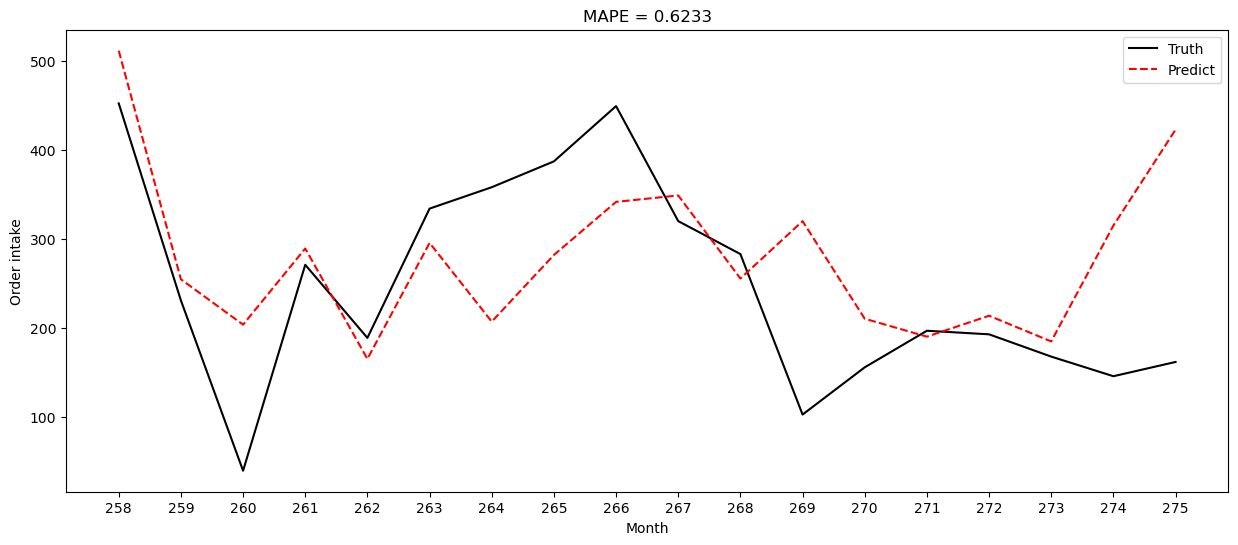

0.6233033889590137

In [6]:
import pmdarima as pm

class SARIMAXModel(Model):
    def __init__(self, data_block, exo=True, predict_periods=TEST_PERIOD):
        super().__init__(data_block)

        self.exogenous_data_train = None
        self.exogenous_data_test = None
        if exo:
            self.exogenous_data_train = self.train_data.drop(TARGET_COL_NAME, axis=1)
            self.exogenous_data_val = self.val_data.drop(TARGET_COL_NAME, axis=1)

        self.model : pm.arima.ARIMA = None
        self.predict_periods = predict_periods

    def train(self):
        # https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
        # Find the best model using stepwise algorithm outlined in Hyndman and Khandakar (2008)
        self.sarima = pm.auto_arima(y=self.y_train, # target
                                    X=self.exogenous_data_train, # data
                                    start_p=0, max_p=5,
                                    start_q=0, max_q=5, # maximum p and q
                                    start_P=0, max_P=5,
                                    start_Q=0, max_Q=5, 
                                    d=None,              # usual differencing
                                    D=None,              # seasonal differencing
                                    seasonal=True,   # Seasonality
                                    m=12,              # frequency of series
                                    test='adf',       # use adftest to find optimal 'd'
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True,
                                    scoring='mse', # mae/mse
                                    stepwise=True)

    def predict(self):
        y_predict = self.sarima.predict(n_periods=self.predict_periods, X=self.exogenous_data_val)
        return y_predict

SARIMAX_model = SARIMAXModel(data_cv[0])
SARIMAX_model.run_eval()

### XGBoost


Preprocessing data...
Training...

Evaluating...


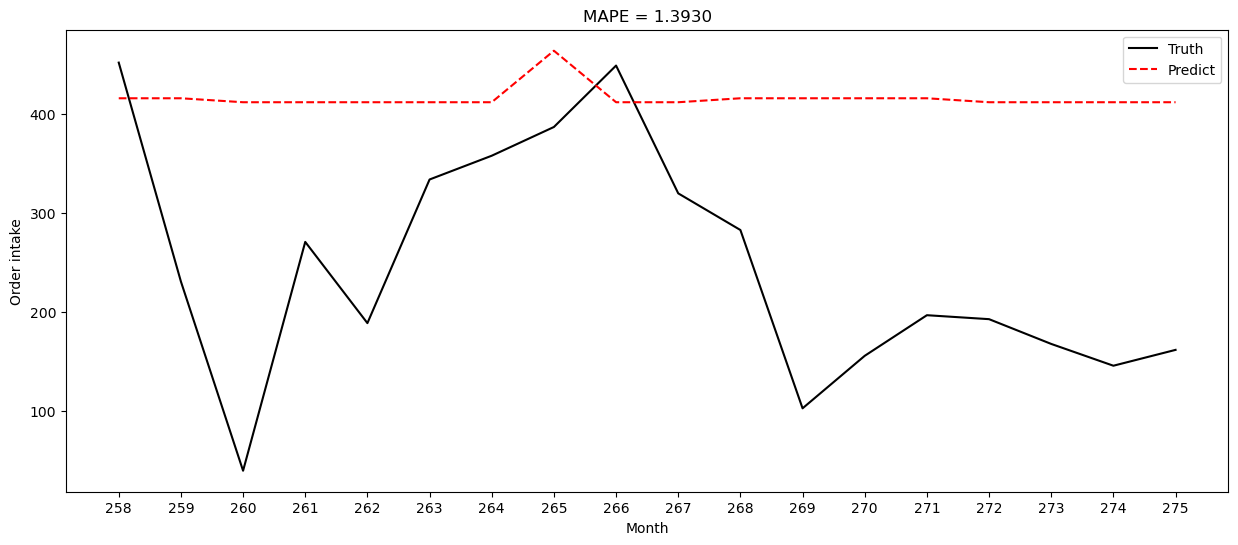

1.3929667113906805

In [7]:
import xgboost

class XGBoostModel(Model):
    def __init__(self, data_block):
        super().__init__(data_block)
        self.preprocessing()
        self.model = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mae")

    def preprocessing(self):
        """Main idea: Use past input data to predict future target value
            For target value:
                - Val: No change
                - Train: Don't use the first {TEST_PERIOD} months of target train
            For input data:
                - Train: Don't use the last {TEST_PERIOD} months of input data train
                - Val: Use the last {TEST_PERIOD} months of input data train
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.iloc[TEST_PERIOD:]
        self.X_train = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[:-TEST_PERIOD, :]
        self.X_val = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[-TEST_PERIOD:, :]

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def predict(self):
        return self.model.predict(self.X_val)
    
XGBoost_model = XGBoostModel(data_cv[0])
XGBoost_model.run_eval()

### Prophet

Importing plotly failed. Interactive plots will not work.
03:46:11 - cmdstanpy - INFO - Chain [1] start processing



Preprocessing data...
Training...


03:46:11 - cmdstanpy - INFO - Chain [1] done processing



Evaluating...


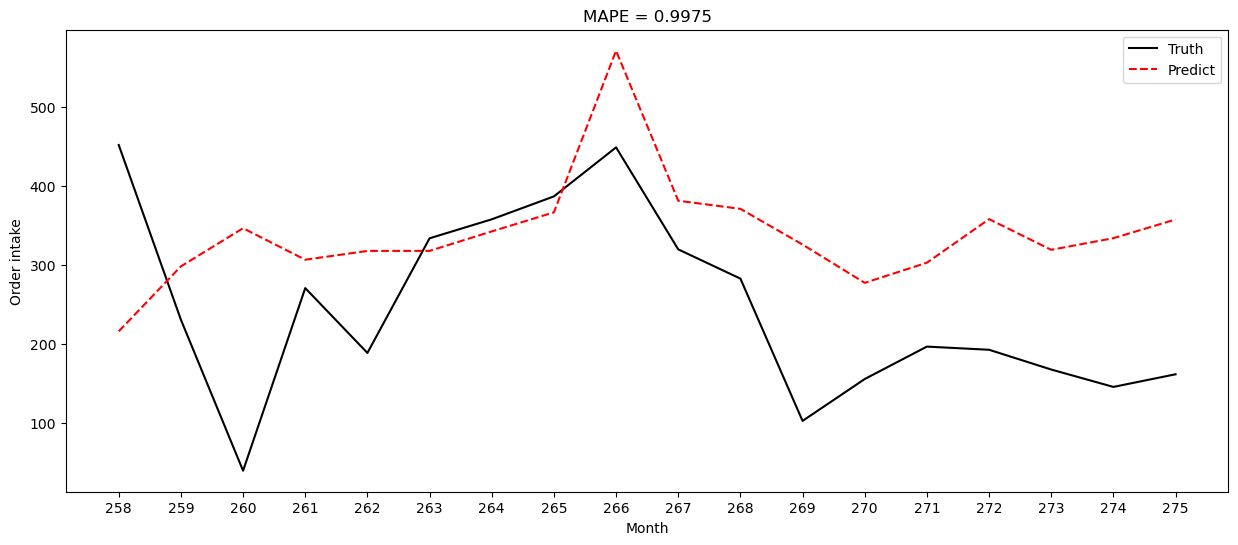

0.9975395534502992

In [8]:
from prophet import Prophet

class ProphetModel(Model):
    def __init__(self, data_block, predict_periods=TEST_PERIOD) -> None:
        super().__init__(data_block)
        self.preprocessing()
        self.model = Prophet(yearly_seasonality=True)
        self.predict_periods = predict_periods

    def preprocessing(self):
        """Expect to have at least 2 columns 'ds' (YYYY-MM-DD) and 'y'
            https://facebook.github.io/prophet/docs/quick_start.html#python-api    
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.reset_index(drop=True)
        self.y_train = pd.DataFrame({'ds': range(len(self.y_train)), 'y': self.y_train.values})
        start_date = '2000-01-01'  # Adjust this date to your needs
        self.y_train['ds'] = pd.to_datetime(self.y_train['ds'].apply(lambda x: pd.DateOffset(months=x) + pd.Timestamp(start_date)))

    def train(self):
        self.model.fit(self.y_train) 

    def predict(self):
        future = self.model.make_future_dataframe(periods=self.predict_periods, freq = "MS")
        forecast = self.model.predict(future)
        predict = forecast.loc[len(self.y_train):, 'yhat']
        return predict

prophet_model = ProphetModel(data_cv[0])
prophet_model.run_eval()

# Pipeline

In [10]:
model_list = {
    "arima": SARIMAXModel,
    "prophet": ProphetModel,
    "xgboost": XGBoostModel,
}

model_perf = {}
for name, model in model_list.items():
    model_perf[name] = [model(data).run_eval(verbose=False) for data in data_cv.values()]

Training...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=631.072, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=633.468, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=635.110, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=629.193, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=631.572, Time=0.41 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=632.312, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=633.088, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=633.014, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=633.911, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=635.499, Time=0.33 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 3.089 seconds

Evaluating...
Training...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=667.643, Time=0.09 sec


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=664.436, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=662.794, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=665.732, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=667.478, Time=0.30 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=669.101, Time=0.48 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=664.329, Time=0.71 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=664.135, Time=0.40 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=666.452, Time=0.82 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=661.779, Time=0.40 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=667.408, Time=0.43 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=663.761, Time=0.66 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=663.221, Time=0.38 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=665.448, Time=0.75 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=662.701, Time=0.41 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=661.275, Time=0.43 sec
 ARIMA(1,0

/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=683.457, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=671.295, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=679.419, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=672.049, Time=0.30 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=672.028, Time=0.50 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=671.701, Time=0.69 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=669.776, Time=0.40 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=672.120, Time=0.74 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=673.650, Time=0.73 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=683.101, Time=0.38 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=669.995, Time=0.47 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=667.505, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=666.093, Time=0.34 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=667.631, Time=0.48 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=672.106, Time=0.52 sec
 ARIMA(1,0

/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=695.235, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=683.066, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=697.131, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=683.555, Time=0.29 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=685.091, Time=0.49 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=685.041, Time=0.72 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=683.595, Time=0.40 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=686.859, Time=0.81 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=699.951, Time=0.38 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=685.132, Time=0.44 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=695.276, Time=0.38 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=678.921, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=680.188, Time=0.31 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=681.003, Time=0.50 sec
 ARIMA(1,1,2)(

/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Evaluating...

Preprocessing data...
Training...

Evaluating...

Preprocessing data...
Training...


03:48:28 - cmdstanpy - INFO - Chain [1] start processing
03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing



Evaluating...

Preprocessing data...
Training...

Evaluating...

Preprocessing data...
Training...


03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing
03:48:28 - cmdstanpy - INFO - Chain [1] done processing
03:48:28 - cmdstanpy - INFO - Chain [1] start processing



Evaluating...

Preprocessing data...
Training...

Evaluating...

Preprocessing data...
Training...


03:48:28 - cmdstanpy - INFO - Chain [1] done processing



Evaluating...


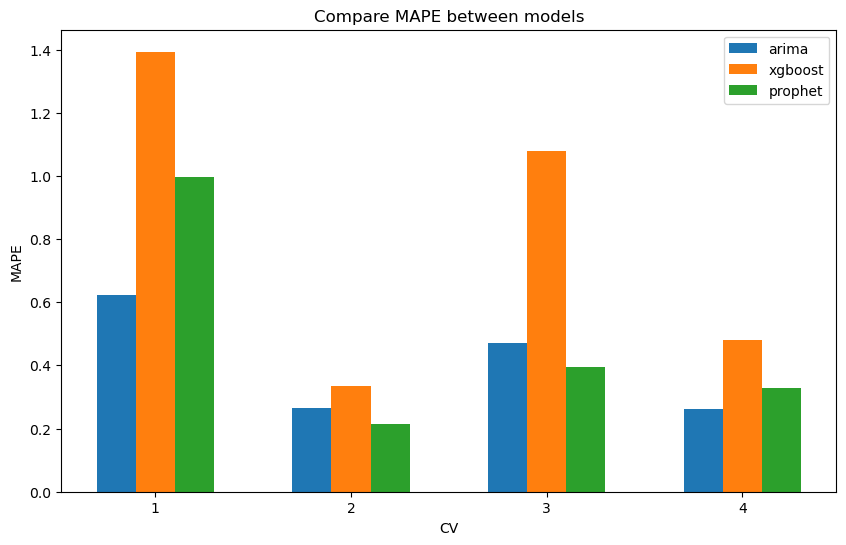

In [15]:
# Visualize result

models = list(model_perf.keys())
perf = list(model_perf.values())

# Number of data blocks
num_cv = len(perf[0])

# Width of each bar
bar_width = 0.2

# Position of each bar on X-axis
x = range(num_cv)

# Plotting each cluster
plt.figure(figsize=(10,6))
for i, name in enumerate(models):
    plt.bar([pos + i * bar_width for pos in x], perf[i], bar_width, label=name)

# Adding labels and title
plt.xlabel('CV')
plt.ylabel('MAPE')
plt.title('Compare MAPE between models')
plt.xticks([pos + (len(models) - 1) * bar_width / 2 for pos in x], range(1, num_cv + 1))
plt.legend()

# Show plot
plt.show()

# Inference on unseen data, i.e train with all dataset to make the final prediction

In [16]:
SARIMAX_model = SARIMAXModel({"train": prod_set.iloc[:TEST_INDEX, :], "val": prod_set.iloc[TEST_INDEX:, :]})
SARIMAX_model.train()
prediction = SARIMAX_model.predict()
print("Our prediction:", prediction.to_list())

plt.plot(range(TEST_INDEX), dev_set.loc[:, TARGET_COL_NAME], label="Current data")
plt.plot(range(TEST_INDEX, TEST_INDEX+TEST_PERIOD), prediction, label="Future prediction")
plt.xticks([0, TEST_INDEX, TEST_INDEX+TEST_PERIOD])
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3002.204, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2940.660, Time=0.90 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2963.425, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3021.703, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2950.595, Time=0.25 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2935.330, Time=1.90 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2937.318, Time=14.67 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2937.387, Time=2.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=2935.162, Time=0.99 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2944.449, Time=0.88 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2939.994, Time=2.12 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=2937.654, Time=1.86 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=2939.135, Time=2.23 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(2,0,0)(1,0,1)[12

Our prediction: [150.17256983349452, 182.16220195450734, 195.1222143515705, 201.5026124015838, 194.38507344126944, 195.06725428765515, 233.13552940884503, 230.48671896437114, 211.57252338077575, 186.25715055678776, 170.83877042253243, 202.28063458789578, 166.99859309631518, 181.75509105921589, 198.85592594933976, 200.38658181908605, 193.1462782486547, 205.48380975736526]


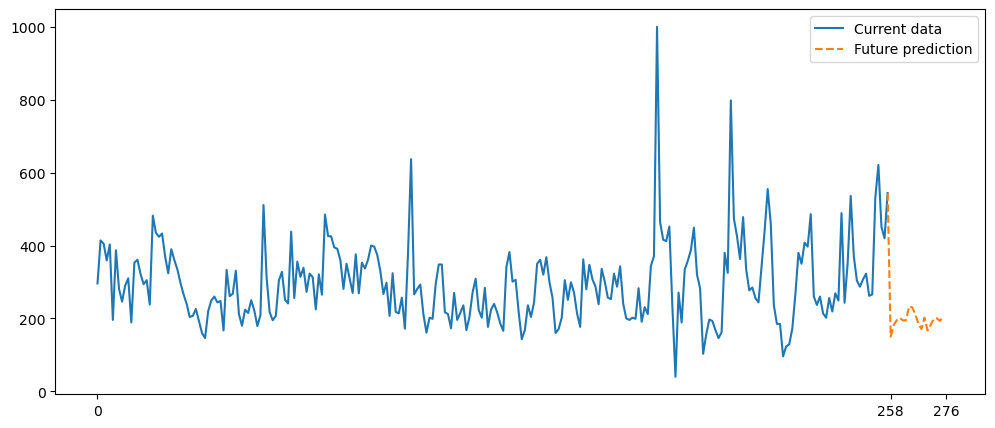

In [39]:
print("Our prediction:", prediction.to_list())

plt.figure(figsize=(12,5))
current_demand = dev_set.loc[:, TARGET_COL_NAME].tolist()
plt.plot(range(TEST_INDEX), current_demand, label="Current data")
plt.plot(range(TEST_INDEX-1, TEST_INDEX+TEST_PERIOD), [current_demand[-1]] + prediction.tolist(), linestyle="--", label="Future prediction")
plt.xticks([0, TEST_INDEX, TEST_INDEX+TEST_PERIOD])
plt.legend()
plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.histplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Add vertical lines for mean and median
#     plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axvline(x=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.xlabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Distrubtion plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend()
# plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.lineplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Vertical line for missing position
#     missing_indices = tiny_data[col][tiny_data[col].isnull()].index
#     plt.axvline(x=missing_indices[0], color='green', linestyle=':', linewidth=0.7, label="Missing")
#     for missing_index in missing_indices[1:]:
#         plt.axvline(x=missing_index, color='green', linestyle=':', linewidth=0.7)  

#     # Add vertical lines for mean and median
#     plt.axhline(y=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axhline(y=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.ylabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Time series plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend(loc='lower right', bbox_to_anchor=(2, 0), ncol=1)
# plt.show()

### Check for autocorrelation

In [ ]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(target.diff(12).dropna(), lags=50)
# plot_pacf(target.diff(12).dropna(), lags=50)
# pyplot.show()

# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(target.dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# result = seasonal_decompose(target.dropna(), model='additive', period=12)
# plt.figure(figsize=(20,6))
# result.plot()
# plt.show()

In [ ]:
p = 1
q = 2
# ARIMA(p,d,q) = (1,0,2)

In [ ]:
exo_data = tiny_data.loc[:, ["sales_actuals_monthly__orderintake", "leasing_contracts__end"]].dropna(axis=0) # "leasing_contracts__start"
start_date = '2024-01-01'
start_date = pd.to_datetime(start_date)
exo_data.index = pd.date_range(start=start_date, periods=len(exo_data), freq='MS')
exo_data

In [ ]:
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4, gap=6, test_size=18)

non_na_data = tiny_data.dropna()
X_in = non_na_data.drop("sales_actuals_monthly__orderintake", axis=1)
y = non_na_data["sales_actuals_monthly__orderintake"]

importances_mean = []
importances_std = []
for i, (train_index, test_index) in enumerate(tscv.split(X_in, y)):
    print(train_index, test_index)
    X_train, y_train = X_in.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X_in.iloc[test_index], y.iloc[test_index]
    model = XGBRegressor().fit(X_train, y_train)
    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10,
        scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
        random_state=0
    )

    importances_mean.append(result.importances_mean)
    importances_std.append(result.importances_std)

In [ ]:
feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_in.columns).sort_values(ascending=True)
feature_importance_df.plot.barh()
plt.title("Permutation importance (the larger the better)")
plt.xlabel("Decrease in MAE score")
plt.plot()

In [ ]:
vehicle_group_list = [f'{i:02}' for i in range(1, 65)]
country_list = [f'Country {name}' for name in ['A', 'B', 'C', 'D']]
print(vehicle_group_list)
print(country_list)

In [ ]:
in_correlation = X_in.corrwith(y)
print(in_correlation[abs(in_correlation) > 0.39])
colors = ['red' if abs(val) > 0.39 else 'grey' for val in in_correlation]
ax = in_correlation.plot.barh(color=colors)
ax.axvline(x=0.39, color='black', linestyle='dotted')
ax.set_xticks([0.39])
yticks = ax.get_yticklabels()
ytick_labels = [label.get_text().replace("__vehiclegroup01__", "_") for label in yticks]
ax.set_yticklabels(ytick_labels)
plt.show()

## External features

In [ ]:
# X_ex = external_data.iloc[non_na_data.index,:].drop(columns=['month'])

# importances_mean = []
# importances_std = []
# for i, (train_index, test_index) in enumerate(tscv.split(X_ex, y)):
#     print(train_index, test_index)
#     X_train, y_train = X_ex.iloc[train_index], y.iloc[train_index]
#     X_val, y_val = X_ex.iloc[test_index], y.iloc[test_index]
#     model = XGBRegressor().fit(X_train, y_train)
#     result = permutation_importance(
#         model,
#         X_val,
#         y_val,
#         n_repeats=10,
#         scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
#         random_state=0
#     )

#     importances_mean.append(result.importances_mean)
#     importances_std.append(result.importances_std)

# feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_ex.columns).sort_values(ascending=True)[:20]
# feature_importance_df.plot.barh()
# plt.title("Permutation importance (the larger the better)")
# plt.xlabel("Decrease in MAE score")
# plt.plot()

In [ ]:
# ex_correlation = X_ex.corrwith(y)
# plt.figure(figsize=(15, 6))
# ex_correlation.plot.box(vert=False)
# plt.show()

The middle 50% of the data (interquartile range) has value smaller quite small. We visualize only features with correlation larger than +-0.4

In [ ]:
# large_corr_ex_features = ex_correlation[abs(ex_correlation) > 0.4]
# print(large_corr_ex_features)

In [ ]:
# plt.barh(large_corr_ex_features.index, large_corr_ex_features.values)
# plt.show()

## Visualize number of features for each vehicle group

In [ ]:
# vec_dict = {}
# for veh in vehicle_group_list:
#     vec_dict[veh] = len(internal_data.filter(regex=f"vehiclegroup{veh}").columns)

# df_temp = pd.DataFrame(vec_dict.items(), columns=['Vehicle group', 'No. of features'])

# plt.figure(figsize=(14, 7), facecolor='white')
# colors = ['red' if i in [49, 52, 55] else 'grey' for i in range(1, len(df_temp)+1)]
# colors[:6] = ["lightblue"] * 6
# plt.bar(df_temp['Vehicle group'], df_temp['No. of features'], color=colors, edgecolor='none')
# plt.axhline(y=5, xmax=0.82, color='black', linestyle='dotted')

# plt.xlabel('Vehicle group', fontsize=15)
# plt.ylabel('No. of features', fontsize=15)
# plt.title('Number of features for each vehicle group', fontsize=25)
# plt.xticks(["01", "06"] + ["49", "52", "55"], fontsize=10)
# plt.yticks([5,15,18], fontsize=15)
# plt.tight_layout()
# plt.box(False)
# plt.savefig("../img/vehicle_vs_internal_features.png", bbox_inches='tight')
# plt.show()